In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
train_path = "./MRIscans/Training"
test_path = "./MRIscans/Testing"
val_path = "./MRIscans/Validation"

In [28]:
def load_images(data_path, data_set_type: str):
    images = []
    
    if data_set_type == "train":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'tumor':
                path = os.path.join(data_path+'/', f)
                for img in os.listdir(path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        # Resize images to all have same dimensions -> avoid large image data problems
                        new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = new_img_array.astype(float, copy=False)/255  
                        images.append(new_img_array)
                        
    elif data_set_type == "test":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'no_tumor':
                path = os.path.join(data_path+'/', f)
                for img in os.listdir(path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255  
                        images.append(new_img_array)
    else:
        for f in os.listdir(data_path):
            if f != '.DS_Store':
                validation_path = os.path.join(data_path+'/', f)
                try:
                    for img in os.listdir(os.path.abspath(validation_path)):
                        
                        if img.endswith(".jpeg") or img.endswith(".jpg"):
                            img_array = cv2.imread(os.path.join(validation_path, img), cv2.IMREAD_GRAYSCALE)
                            new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                            # normalize pixel values to be between 0 and 1
                            new_img_array = new_img_array.astype(float, copy=False)/255  
                            images.append(new_img_array)
                except Exception as e:
                    raise e

                    
    return images

In [4]:
train_data = load_images(train_path, 'train')

test_data = load_images(test_path, 'test')

Number of training samples: 6636; Number of test samples: 2633


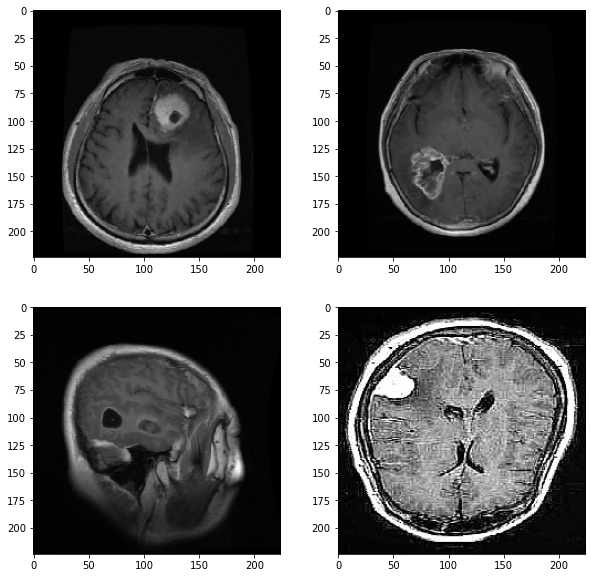

In [33]:
n_train_examples, n_test_examples = len(train_data), len(test_data)
print(f"Number of training samples: {n_train_examples}; Number of test samples: {n_test_examples}")

# Plot some images from train and test sets
train_imgs = train_data[0:5]
test_imgs = test_data[0:5]


plt.figure(figsize=(10, 10))
l =2
w = 2
for i in range(l*w):
    plt.subplot(l, w, i+1)
    plt.grid(False)
    plt.imshow(train_imgs[i], cmap='gray')
    plt.axis('on')

plt.show()

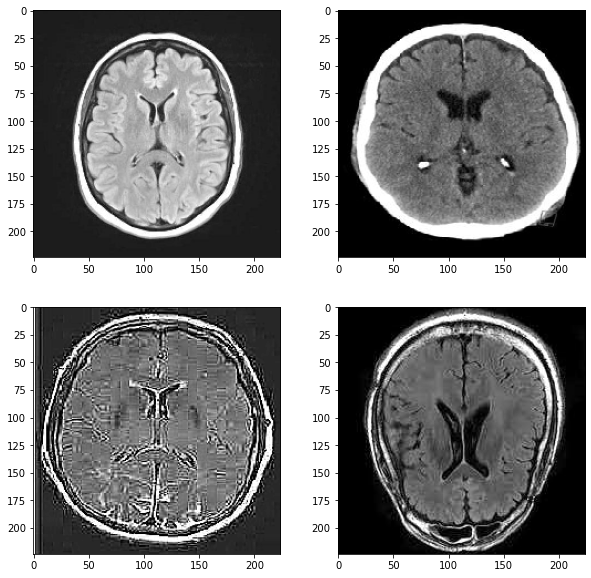

In [34]:
plt.figure(figsize=(10, 10))
l =2
w = 2
for i in range(l*w):
    plt.subplot(l, w, i+1)
    plt.grid(False)
    plt.imshow(test_imgs[i], cmap='gray')
    plt.axis('on')

plt.show()

# Start Preprocessing

- Standardization: scale pixel values to have 0 mean and unit variance
- Noise reduction: remove any noise if present using cv2. ref: https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html
- Additional preprocessing steps...